### Objective

The Ultimate goal of this task would be to identify opportunities to increase the occupancy rate on low-performing flights,which can ulitmately lead to increased profitability for the airline.

### Importing Libraries

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Database Connection

In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/airline-data-analysis/data/travel.sqlite')
cursor = conn.cursor()

In [ ]:
cursor.execute("""select name from sqlite_master where type='table';""")
print('List of tables present in the DB')
table_list = [table[0] for table in cursor.fetchall()]
table_list

List of tables present in the DB


['aircrafts_data',
 'airports_data',
 'boarding_passes',
 'bookings',
 'flights',
 'seats',
 'ticket_flights',
 'tickets']

### Data Exploration

In [ ]:
aircrafts_data = pd.read_sql_query("select * from aircrafts_data", conn)
# aircrafts_data

In [ ]:
airports_data = pd.read_sql_query("select * from airports_data", conn)
# airports_data

In [ ]:
boarding_passes = pd.read_sql_query("select * from boarding_passes", conn)
# boarding_passes

In [ ]:
bookings = pd.read_sql_query("select * from bookings", conn)
# bookings

In [ ]:
flights = pd.read_sql_query("select * from flights", conn)
# flights

In [ ]:
seats = pd.read_sql_query("select * from seats", conn)
# seats

In [ ]:
ticket_flights = pd.read_sql_query("select * from ticket_flights", conn)
# ticket_flights

In [ ]:
tickets = pd.read_sql_query("select * from tickets", conn)
# tickets

In [ ]:
table_list

['aircrafts_data',
 'airports_data',
 'boarding_passes',
 'bookings',
 'flights',
 'seats',
 'ticket_flights',
 'tickets']

In [ ]:
cnt = 1
for table in table_list:
  print('\ntable{} : {}'.format(cnt, table))
  cnt += 1

  col_info = conn.execute('PRAGMA table_info({})'.format(table))
  # print(col_info)

  for col in col_info.fetchall():
    print(col[1:3])


table1 : aircrafts_data
('aircraft_code', 'character(3)')
('model', 'jsonb')
('range', 'INTEGER')

table2 : airports_data
('airport_code', 'character(3)')
('airport_name', 'jsonb')
('city', 'jsonb')
('coordinates', 'point')
('timezone', 'TEXT')

table3 : boarding_passes
('ticket_no', 'character(13)')
('flight_id', 'INTEGER')
('boarding_no', 'INTEGER')
('seat_no', 'character varying(4)')

table4 : bookings
('book_ref', 'character(6)')
('book_date', 'timestamp with time zone')
('total_amount', 'numeric(10,2)')

table5 : flights
('flight_id', 'INTEGER')
('flight_no', 'character(6)')
('scheduled_departure', 'timestamp with time zone')
('scheduled_arrival', 'timestamp with time zone')
('departure_airport', 'character(3)')
('arrival_airport', 'character(3)')
('status', 'character varying(20)')
('aircraft_code', 'character(3)')
('actual_departure', 'timestamp with time zone')
('actual_arrival', 'timestamp with time zone')

table6 : seats
('aircraft_code', 'character(3)')
('seat_no', 'charact

In [ ]:
#Checking Null/NaN values in the data
cnt=1

for table in table_list:
  print(f'\ntable{cnt}: ', table)
  df_table = pd.read_sql_query(f"select * from {table}", conn)
  print(df_table.isnull().sum())
  cnt += 1


table1:  aircrafts_data
aircraft_code    0
model            0
range            0
dtype: int64

table2:  airports_data
airport_code    0
airport_name    0
city            0
coordinates     0
timezone        0
dtype: int64

table3:  boarding_passes
ticket_no      0
flight_id      0
boarding_no    0
seat_no        0
dtype: int64

table4:  bookings
book_ref        0
book_date       0
total_amount    0
dtype: int64

table5:  flights
flight_id              0
flight_no              0
scheduled_departure    0
scheduled_arrival      0
departure_airport      0
arrival_airport        0
status                 0
aircraft_code          0
actual_departure       0
actual_arrival         0
dtype: int64

table6:  seats
aircraft_code      0
seat_no            0
fare_conditions    0
dtype: int64

table7:  ticket_flights
ticket_no          0
flight_id          0
fare_conditions    0
amount             0
dtype: int64

table8:  tickets
ticket_no       0
book_ref        0
passenger_id    0
dtype: int64


###Basic Analysis

**How many planes have more than 100 seats ?**

In [ ]:
pd.read_sql_query("""select aircraft_code, count(*) as num_of_seats from seats
  group by aircraft_code having num_of_seats > 100""", conn)

,aircraft_code,num_of_seats
0,319,116
1,320,140
2,321,170
3,733,130
4,763,222
5,773,402


**How the number of tickets booked and total amount earned changed with the time.**

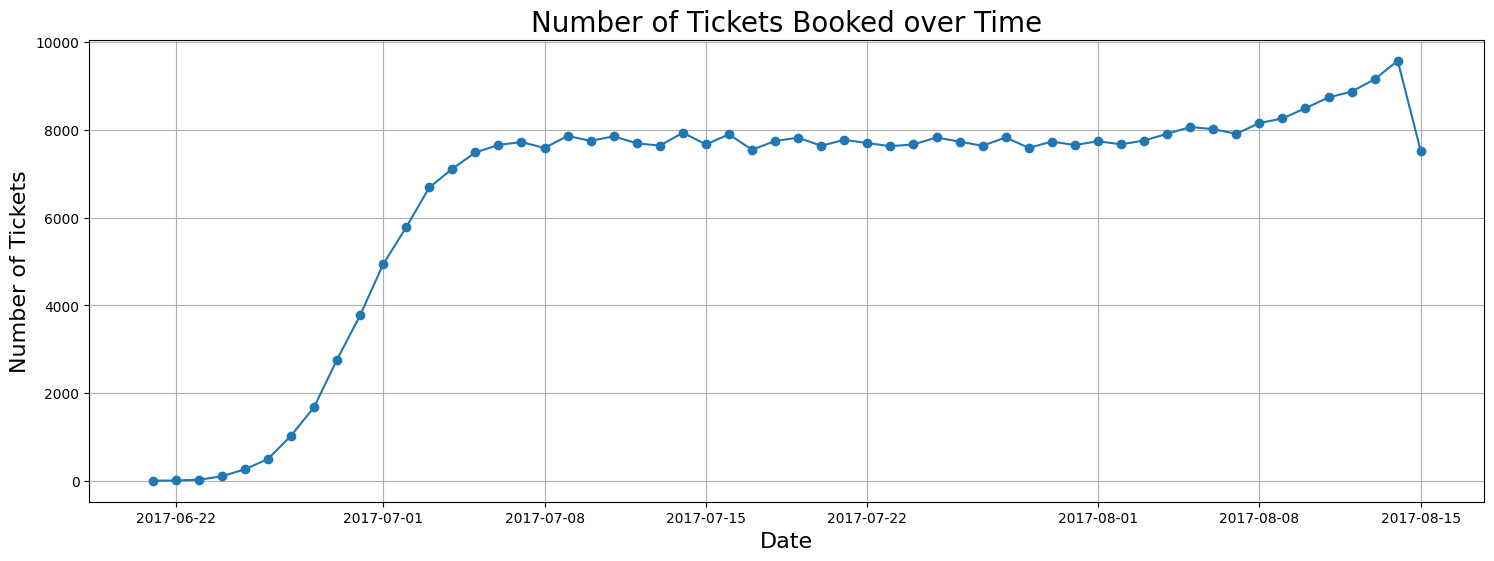

In [ ]:
tickets = pd.read_sql_query("""select * from tickets inner join bookings on
tickets.book_ref = bookings.book_ref""", conn)

# tickets.dtypes
tickets['book_date'] = pd.to_datetime(tickets['book_date'])
tickets['date'] = tickets['book_date'].dt.date
x = tickets.groupby('date')[['date']].count()

plt.figure(figsize=(18, 6))
plt.plot(x.index, x['date'], marker='o')

plt.title('Number of Tickets Booked over Time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Tickets', fontsize=16)
plt.grid(True)
plt.savefig('ticket_bookings_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.ticker as mticker

# Indian number formatter (Lakhs / Crores)
def indian_format(x, _):
    if x >= 1e7:
        return f'{x/1e7:.1f} Cr'
    elif x >= 1e5:
        return f'{x/1e5:.1f} L'
    else:
        return f'{x:,.0f}'


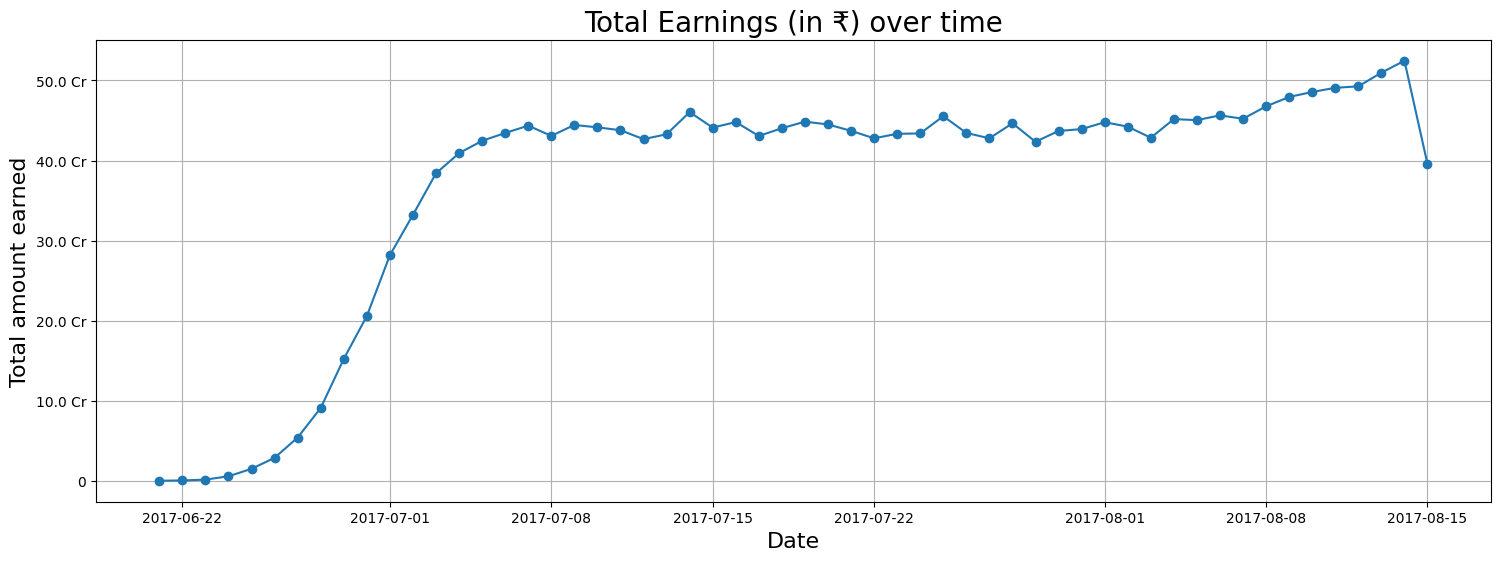

In [ ]:
bookings = pd.read_sql_query("select * from bookings", conn)
bookings['book_date'] = pd.to_datetime(bookings['book_date'])
bookings['date'] = bookings['book_date'].dt.date
x = bookings.groupby('date')[['total_amount']].sum()

plt.figure(figsize=(18, 6))
plt.plot(x.index, x['total_amount'], marker='o')


# Apply Indian number format to Y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(indian_format))

plt.title('Total Earnings (in ₹) over time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total amount earned', fontsize=16)
plt.grid(True)
plt.savefig('total_earnings_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

**Calculate the average charges for each aircraft with different fare conditions.**

In [ ]:
df = pd.read_sql_query("""select fare_conditions, aircraft_code, avg(amount)
                  from ticket_flights join flights on ticket_flights.flight_id=flights.flight_id
                  group by aircraft_code, fare_conditions""", conn)
df

,fare_conditions,aircraft_code,avg(amount)
0,Business,319,113550.55770292656
1,Economy,319,38311.40234713914
2,Business,321,34435.66266431457
3,Economy,321,11534.97476439323
4,Business,733,41865.626175253856
5,Economy,733,13985.152
6,Business,763,82839.84286649604
7,Economy,763,27594.7218286053
8,Business,773,57779.90943535718
9,Comfort,773,32740.552888786075


In [ ]:
df.columns

Index(['fare_conditions', 'aircraft_code', 'avg(amount)'], dtype='object')

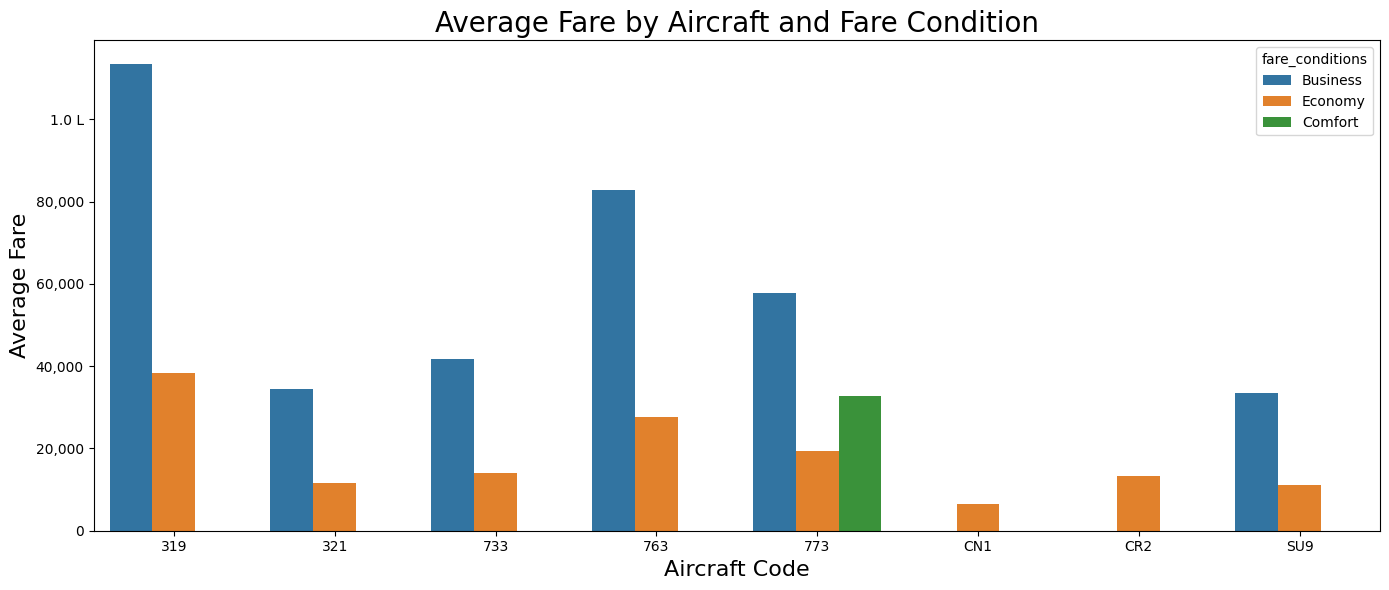

In [ ]:
plt.figure(figsize=(14, 6))

sns.barplot(data=df, x=df['aircraft_code'], y=df['avg(amount)'], hue='fare_conditions')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(indian_format))

plt.xlabel('Aircraft Code', fontsize=16)
plt.ylabel('Average Fare', fontsize=16)
plt.title('Average Fare by Aircraft and Fare Condition', fontsize=20)
plt.tight_layout()
plt.savefig('average_fare_by_aircraft.png', dpi=300, bbox_inches='tight')
plt.show()

### Analyzing occupancy rate

**For each aircraft, calculate the total revenue per year and the average revenue per ticket.**

In [ ]:
pd.read_sql_query("""select aircraft_code, ticket_count, total_revenue, total_revenue/ticket_count as avg_revenue_per_ticket
                  from
                  (select aircraft_code, count(*) as ticket_count, sum(amount) as total_revenue
                  from ticket_flights join flights on ticket_flights.flight_id=flights.flight_id
                  group by aircraft_code)""", conn)

,aircraft_code,ticket_count,total_revenue,avg_revenue_per_ticket
0,319,52853,2706163100,51201
1,321,107129,1638164100,15291
2,733,86102,1426552100,16568
3,763,124774,4371277100,35033
4,773,144376,3431205500,23765
5,CN1,14672,96373800,6568
6,CR2,150122,1982760500,13207
7,SU9,365698,5114484700,13985


**Calculate the average occupancy per aircraft.**

In [ ]:
occupancy_rate = pd.read_sql_query(f"""
select a.aircraft_code, avg(a.seats_count) as booked_seats, b.num_seats,
       round((avg(a.seats_count) / b.num_seats) * 100, 2) as occupancy_rate
from (
    select aircraft_code, flights.flight_id, count(*) as seats_count
    from boarding_passes
    inner join flights
        on boarding_passes.flight_id = flights.flight_id
    group by aircraft_code, flights.flight_id
) as a
inner join (
    select aircraft_code, count(*) as num_seats
    from seats
    group by aircraft_code
) as b
on a.aircraft_code = b.aircraft_code
group by a.aircraft_code
""", conn)

occupancy_rate

,aircraft_code,booked_seats,num_seats,occupancy_rate
0,319,53.58318098720292,116,46.19
1,321,88.80923076923077,170,52.24
2,733,80.25546218487395,130,61.73
3,763,113.93729372937294,222,51.32
4,773,264.9258064516129,402,65.9
5,CN1,6.004431314623338,12,50.04
6,CR2,21.48284690220174,50,42.97
7,SU9,56.81211267605634,97,58.57


**Calculate by how much the total annual turnover could increase by giving all aircraft a 10% higher occupancy rate.**

In [ ]:
occupancy_rate['Inc occupancy rate'] = occupancy_rate['occupancy_rate'] + occupancy_rate['occupancy_rate']*0.1
occupancy_rate

,aircraft_code,booked_seats,num_seats,occupancy_rate,Inc occupancy rate
0,319,53.58318098720292,116,46.19,50.809
1,321,88.80923076923077,170,52.24,57.464
2,733,80.25546218487395,130,61.73,67.90299999999999
3,763,113.93729372937294,222,51.32,56.452
4,773,264.9258064516129,402,65.9,72.49000000000001
5,CN1,6.004431314623338,12,50.04,55.044
6,CR2,21.48284690220174,50,42.97,47.266999999999996
7,SU9,56.81211267605634,97,58.57,64.427


In [ ]:
pd.set_option('display.float_format', str)

In [ ]:
total_revenue = pd.read_sql_query("""select aircraft_code, sum(amount) as total_revenue from ticket_flights
                  join flights on ticket_flights.flight_id=flights.flight_id group by aircraft_code""", conn)
occupancy_rate['Inc Total Annual Turnover'] = (total_revenue['total_revenue']/occupancy_rate['occupancy_rate'])*occupancy_rate['Inc occupancy rate']
occupancy_rate

,aircraft_code,booked_seats,num_seats,occupancy_rate,Inc occupancy rate,Inc Total Annual Turnover
0,319,53.58318098720292,116,46.19,50.809,2976779410.0
1,321,88.80923076923077,170,52.24,57.464,1801980510.0
2,733,80.25546218487395,130,61.73,67.90299999999999,1569207310.0
3,763,113.93729372937294,222,51.32,56.452,4808404810.0
4,773,264.9258064516129,402,65.9,72.49000000000001,3774326050.0
5,CN1,6.004431314623338,12,50.04,55.044,106011179.99999999
6,CR2,21.48284690220174,50,42.97,47.266999999999996,2181036550.0
7,SU9,56.81211267605634,97,58.57,64.427,5625933170.000001
